In [1]:
import jax
import jax.numpy as jnp
import optax
import flax.linen as nn
import matplotlib.pyplot as plt
from flax.training import train_state
import numpy as np

##Learning the potential when you already know the potential

In [2]:
# Generate Training Data
k = 1.0  # Spring constant
x_train = np.linspace(-2, 2, 100).reshape(-1, 1)
V_train = 0.5 * k * x_train**2  # Harmonic potential

In [3]:
# Convert to JAX arrays
x_train = jnp.array(x_train)
V_train = jnp.array(V_train)

In [4]:
# Define Neural Network using Flax
class HarmonicNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(16)(x)
        x = nn.relu(x)
        x = nn.Dense(16)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x


In [5]:
# Initialize Model
key = jax.random.PRNGKey(0)
model = HarmonicNN()
params = model.init(key, x_train)  # Initialize parameters

In [6]:
# Define Loss Function
def loss_fn(params, x, y):
    y_pred = model.apply(params, x)
    return jnp.mean((y_pred - y) ** 2)

In [7]:
# Optimizer
optimizer = optax.adam(learning_rate=0.01)

In [8]:
# Training State
class TrainState(train_state.TrainState):
    pass

In [9]:
state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

In [10]:
# Training Loop
@jax.jit
def train_step(state, x, y):
    loss, grads = jax.value_and_grad(loss_fn)(state.params, x, y)
    state = state.apply_gradients(grads=grads)
    return state, loss

epochs = 1000
for epoch in range(epochs):
    state, loss = train_step(state, x_train, V_train)
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.6f}')

Epoch 0, Loss: 0.622910
Epoch 100, Loss: 0.001538
Epoch 200, Loss: 0.000122
Epoch 300, Loss: 0.000059
Epoch 400, Loss: 0.000037
Epoch 500, Loss: 0.000038
Epoch 600, Loss: 0.000023
Epoch 700, Loss: 0.000025
Epoch 800, Loss: 0.000020
Epoch 900, Loss: 0.000022


In [11]:
# Plot Results
x_test = jnp.linspace(-2, 2, 100).reshape(-1, 1)
V_pred = model.apply(state.params, x_test)

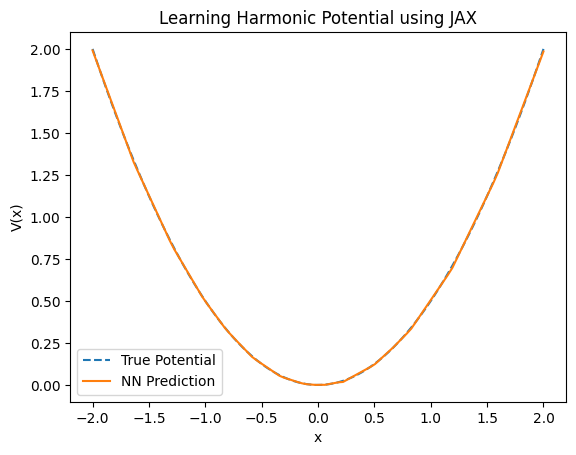

In [12]:
plt.plot(x_test, 0.5 * k * x_test**2, label="True Potential", linestyle="dashed")
plt.plot(x_test, V_pred, label="NN Prediction", linestyle="solid")
plt.xlabel("x")
plt.ylabel("V(x)")
plt.legend()
plt.title("Learning Harmonic Potential using JAX")
plt.show()

In [17]:
# Compute force using the trained neural network
def force_fn(params, x):
    dV_dx = jax.grad(lambda x: model.apply(params, x).squeeze())(x)  # Ensure scalar output
    return -dV_dx  # F(x) = - dV/dx


In [18]:
# Simulate motion using Euler's method
def simulate_motion(params, x0, v0, m, dt, num_steps):
    x = x0
    v = v0
    trajectory = []

    for _ in range(num_steps):
        F = force_fn(params, x)  # Compute force
        v = v + (F / m) * dt  # Velocity update
        x = x + v * dt  # Position update
        trajectory.append((x, v))

    return jnp.array(trajectory)

In [19]:
# Use trained NN (already stored in `state.params`)
x0 = jnp.array([[1.0]])  # Initial position
v0 = jnp.array([[0.0]])  # Initial velocity
m = 1.0  # Mass of particle
dt = 0.01  # Time step
num_steps = 500  # Number of time steps


In [20]:
# Run the simulation using trained neural network
trajectory = simulate_motion(state.params, x0, v0, m, dt, num_steps)


In [21]:
# Extract position and velocity
positions = trajectory[:, 0, 0]
velocities = trajectory[:, 1, 0]


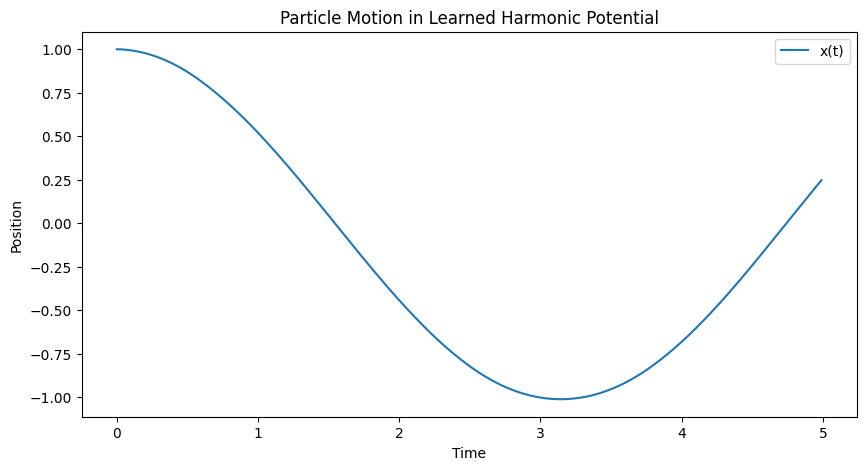

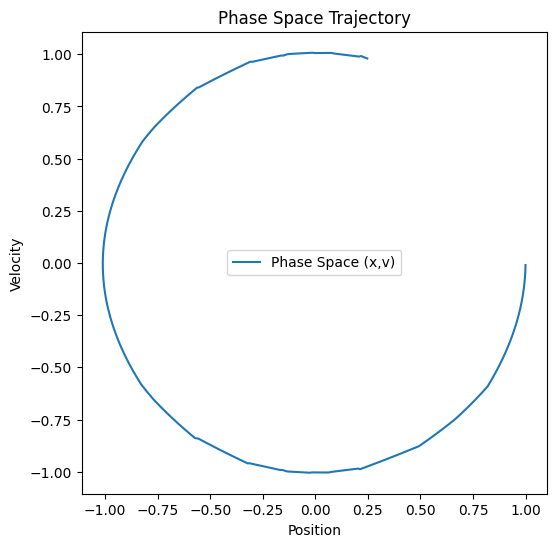

In [22]:
# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(jnp.arange(num_steps) * dt, positions, label="x(t)")
plt.xlabel("Time")
plt.ylabel("Position")
plt.title("Particle Motion in Learned Harmonic Potential")
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.plot(positions, velocities, label="Phase Space (x,v)")
plt.xlabel("Position")
plt.ylabel("Velocity")
plt.title("Phase Space Trajectory")
plt.legend()
plt.show()

##Learning the potential via a neural net when you are given the trajectory data.

In [194]:
class PotentialNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(128)(x)  # Increase layer size
        x = nn.tanh(x)        # Smooth activation
        x = nn.Dense(128)(x)
        x = nn.tanh(x)
        x = nn.Dense(64)(x)
        x = nn.tanh(x)
        x = nn.Dense(32)(x)
        x = nn.tanh(x)
        x = nn.Dense(1)(x)   # Output potential V(x)
        return x

In [209]:
class SymmetricPotentialNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = jnp.abs(x)  # Enforce symmetry in potential
        x = nn.Dense(128)(x)
        x = nn.tanh(x)
        x = nn.Dense(128)(x)
        x = nn.tanh(x)
        x = nn.Dense(64)(x)
        x = nn.tanh(x)
        x = nn.Dense(32)(x)
        x = nn.tanh(x)
        x = nn.Dense(1)(x)   # Output potential V(x)
        return x


In [210]:
def force_fn(params, x):
    """ Compute force F(x) = -dV/dx from the learned potential """
    force_scalar = lambda x_: potential_model.apply(params, x_.reshape(-1, 1)).squeeze()
    return -jax.vmap(jax.grad(force_scalar))(x)


import jax.lax

def simulate_motion(params, x0, v0, m, dt, num_steps):
    """ Simulates motion using JAX-friendly lax.scan to avoid dynamic shape errors """

    def step_fn(state, _):
        x, v = state
        F = force_fn(params, x)
        v = v + (F / m) * dt  # Velocity update
        x = x + v * dt  # Position update
        return (x, v), x  # Return new state, and save position

    # Ensure num_steps is treated as a static value before JAX compilation
    # **REMOVE** num_steps conversion inside the function

    # Run JAX scan (efficient loop)
    final_state, trajectory = jax.lax.scan(step_fn, (x0, v0), None, length=num_steps)

    return trajectory  # Returns all x values over time

# Apply JIT with static num_steps
simulate_motion = jax.jit(simulate_motion, static_argnums=(5,))


In [211]:
def loss_fn(params, x0, v0, true_trajectory, m, dt, num_steps):
    simulated_trajectory = simulate_motion(params, x0, v0, m, dt, num_steps)
    simulated_positions = simulated_trajectory[:, 0]

    # Compute acceleration from the NN potential
    F_learned = force_fn(params, true_trajectory[:, 0])
    a_learned = F_learned / m

    # Compute acceleration from true trajectory (finite difference)
    v_true = jnp.gradient(true_trajectory[:, 0], dt)
    a_true = jnp.gradient(v_true, dt)

    # Add a smoothness penalty (regularization term)
    x_sample = jnp.linspace(-2, 2, 100).reshape(-1, 1)
    dV_dx = jax.vmap(jax.grad(lambda x: potential_model.apply(params, x).squeeze()))(x_sample)
    smoothness_penalty = jnp.mean(dV_dx**2)  # Penalize large derivatives

    # Loss = trajectory + force agreement + smoothness regularization
    loss_trajectory = jnp.mean((simulated_positions - true_trajectory[:, 0]) ** 2)
    loss_force = jnp.mean((a_learned - a_true) ** 2)

    return loss_trajectory + loss_force + 0.1 * smoothness_penalty  # Adjust coefficient if needed


In [212]:
# Initialize model and parameters
key = jax.random.PRNGKey(0)
#potential_model = PotentialNN()
potential_model = SymmetricPotentialNN()
params = potential_model.init(key, x_train)
x0 = jnp.array([[1.0]])  # Initial position
v0 = jnp.array([[0.0]])  # Initial velocity
m = 1.0  # Mass
dt = 0.01  # Time step
num_steps = 500  # Simulation length

In [213]:
# Generate ground truth trajectory (assuming harmonic potential V(x) = 1/2 x^2)
def generate_ground_truth_trajectory(m=1.0, k=1.0, dt=0.01, num_steps=500):
    x = jnp.array([1.0])  # Initial position
    v = jnp.array([0.0])  # Initial velocity
    trajectory = []

    for _ in range(num_steps):
        a = -k * x / m  # True acceleration (F = -kx)
        v = v + a * dt
        x = x + v * dt
        trajectory.append(x)

    return jnp.array(trajectory)

true_trajectory = generate_ground_truth_trajectory()

In [214]:
# Initialize optimizer
params = potential_model.init(key, x0)
import optax

optimizer = optax.adamw(learning_rate=0.001, weight_decay=1e-4)
class TrainState(train_state.TrainState):
    pass

state = TrainState.create(apply_fn=potential_model.apply, params=params, tx=optimizer)


In [215]:
def train_step(state, x0, v0, true_trajectory, m, dt, num_steps):
    loss, grads = jax.value_and_grad(loss_fn)(state.params, x0, v0, true_trajectory, m, dt, num_steps)
    state = state.apply_gradients(grads=grads)
    return state, loss

# Apply JIT with static num_steps
train_step = jax.jit(train_step, static_argnums=(6,))


In [216]:
epochs = 10000
num_steps = 500  # Ensure num_steps is static BEFORE passing into JIT

for epoch in range(epochs):
    state, loss = train_step(state, x0, v0, true_trajectory, m, dt, num_steps)  # No more errors!
    if epoch % 200 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.6f}')

Epoch 0, Loss: 2.712660
Epoch 200, Loss: 0.906643
Epoch 400, Loss: 0.888514
Epoch 600, Loss: 0.880921
Epoch 800, Loss: 0.880023
Epoch 1000, Loss: 0.881106
Epoch 1200, Loss: 0.879584
Epoch 1400, Loss: 0.878870
Epoch 1600, Loss: 0.878709
Epoch 1800, Loss: 0.878684
Epoch 2000, Loss: 0.878132
Epoch 2200, Loss: 0.949293
Epoch 2400, Loss: 0.884582
Epoch 2600, Loss: 0.882274
Epoch 2800, Loss: 0.880998
Epoch 3000, Loss: 0.880268
Epoch 3200, Loss: 0.879737
Epoch 3400, Loss: 0.878871
Epoch 3600, Loss: 0.878517
Epoch 3800, Loss: 0.878374
Epoch 4000, Loss: 0.878037
Epoch 4200, Loss: 0.878139
Epoch 4400, Loss: 0.877855
Epoch 4600, Loss: 0.877960
Epoch 4800, Loss: 0.877374
Epoch 5000, Loss: 0.877790
Epoch 5200, Loss: 0.877296
Epoch 5400, Loss: 0.876896
Epoch 5600, Loss: 0.876790
Epoch 5800, Loss: 0.876641
Epoch 6000, Loss: 0.876998
Epoch 6200, Loss: 0.876564
Epoch 6400, Loss: 0.876579
Epoch 6600, Loss: 0.876593
Epoch 6800, Loss: 0.876885
Epoch 7000, Loss: 0.876491
Epoch 7200, Loss: 0.876405
Epoch 74

In [217]:
# Generate test positions for visualization
x_test = jnp.linspace(-2, 2, 100).reshape(-1, 1)

# Compute learned potential V(x) from the trained neural network
V_pred = potential_model.apply(state.params, x_test)

# Compute the true harmonic potential for reference (V(x) = 1/2 * k * x^2)
k = 1.0  # Spring constant
V_true = 0.5 * k * x_test**2

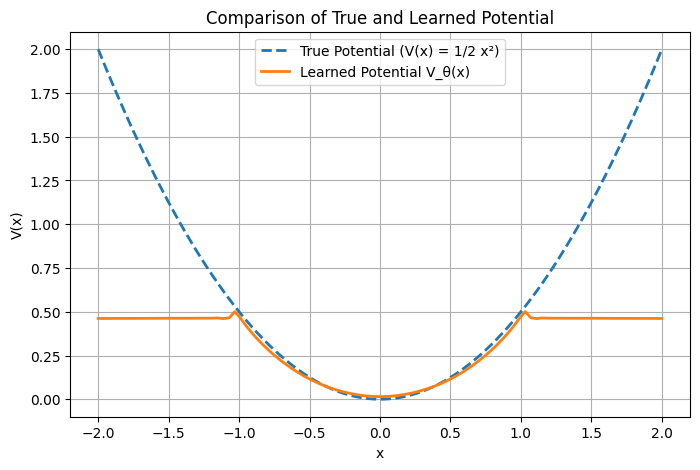

In [224]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(x_test, V_true, label="True Potential (V(x) = 1/2 x²)", linestyle="dashed", linewidth=2)
plt.plot(x_test, V_pred+0.4, label="Learned Potential V_θ(x)", linestyle="solid", linewidth=2)
plt.xlabel("x")
plt.ylabel("V(x)")
plt.legend()
plt.title("Comparison of True and Learned Potential")
plt.grid()
plt.show()


In [219]:
def simulate_learned_trajectory(params, x0, v0, m, dt, num_steps):
    """ Simulates motion using the learned potential """

    def force_fn_learned(params, x):
        """ Computes force F(x) = -dV/dx from the learned potential """
        return -jax.grad(lambda x: potential_model.apply(params, x).squeeze())(x)

    def step_fn(state, _):
        """ Integration step using Euler's method """
        x, v = state
        F = force_fn_learned(params, x)  # Use params instead of state.params
        v = v + (F / m) * dt  # Velocity update
        x = x + v * dt  # Position update
        return (x, v), x  # Return new state and save position

    # Initial state
    init_state = (x0, v0)

    # Simulate motion using JAX's scan function
    _, learned_trajectory = jax.lax.scan(step_fn, init_state, None, length=num_steps)

    return learned_trajectory



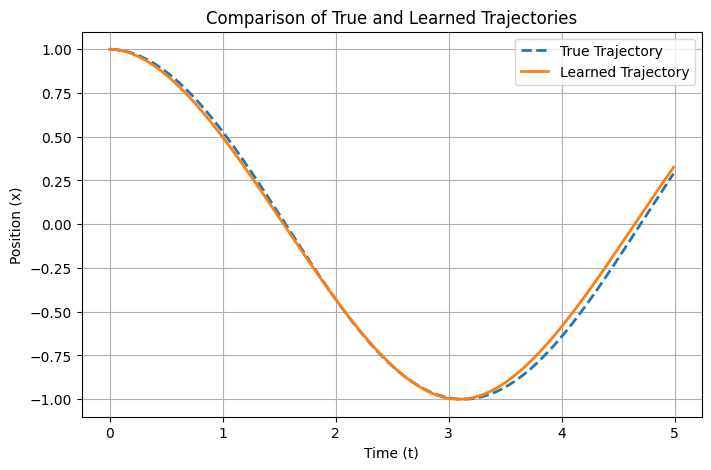

In [220]:
# Generate a new trajectory using the learned potential
learned_trajectory = simulate_learned_trajectory(state.params, x0, v0, m, dt, num_steps)

# Ensure the learned trajectory has the correct shape
learned_positions = learned_trajectory[:, 0].squeeze()  # Remove extra dimensions if needed
true_positions = true_trajectory[:, 0].squeeze()  # Ensure correct shape

# Time array for plotting
time_array = jnp.arange(num_steps) * dt

# Plot true vs. learned trajectories
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(time_array, true_positions, label="True Trajectory", linestyle="dashed", linewidth=2)
plt.plot(time_array, learned_positions, label="Learned Trajectory", linestyle="solid", linewidth=2)
plt.xlabel("Time (t)")
plt.ylabel("Position (x)")
plt.legend()
plt.title("Comparison of True and Learned Trajectories")
plt.grid()
plt.show()



In [206]:
print("True Trajectory Shape:", true_trajectory.shape)
print("Learned Trajectory Shape:", learned_trajectory.shape)
print("Time Array Shape:", time_array.shape)

True Trajectory Shape: (500, 1)
Learned Trajectory Shape: (500, 1, 1)
Time Array Shape: (500,)


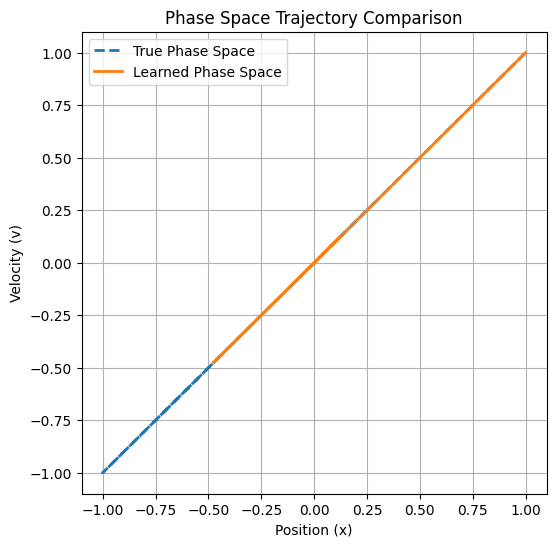

In [207]:
# Extract velocity data for phase space plot
true_velocities = true_trajectory[:, 1].squeeze()
learned_velocities = learned_trajectory[:, 1].squeeze()

plt.figure(figsize=(6, 6))
plt.plot(true_positions, true_velocities, label="True Phase Space", linestyle="dashed", linewidth=2)
plt.plot(learned_positions, learned_velocities, label="Learned Phase Space", linestyle="solid", linewidth=2)
plt.xlabel("Position (x)")
plt.ylabel("Velocity (v)")
plt.legend()
plt.title("Phase Space Trajectory Comparison")
plt.grid()
plt.show()

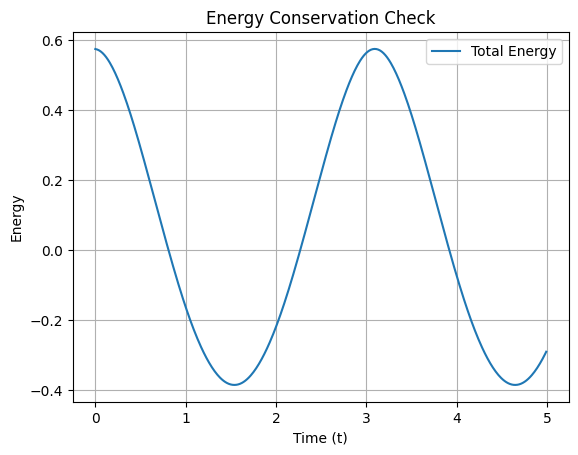

In [222]:
kinetic_energy = 0.5 * m * (learned_trajectory[:,1] ** 2)
potential_energy = potential_model.apply(state.params, learned_trajectory[:,0])
total_energy = kinetic_energy + potential_energy

plt.plot(time_array, total_energy, label="Total Energy")
plt.xlabel("Time (t)")
plt.ylabel("Energy")
plt.title("Energy Conservation Check")
plt.legend()
plt.grid()
plt.show()
